# CS 159 Project: Solving Knapsack Problem with Feedback

In [2]:
import matplotlib.pyplot as plt
import math
import random
import re
import time
from openai import OpenAI
from sys import maxsize
from tqdm import tqdm
from IPython import get_ipython

In [7]:
ipython = get_ipython()
client = OpenAI(api_key = 'sk-proj-zAfbL0i6aR55d0um6PIbT3BlbkFJmv9ZlKICyHqZbZtuvYJo')
pattern = re.compile(r'```python\n(.*?)```', re.DOTALL)

In [147]:
completion = client.chat.completions.create(
    model='gpt-4-turbo',
    messages=[
    {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems.'},
    {'role': 'user', 'content': f'What is a heuristic algorithm for solving the 0/1 knapsack problem? The input is a list of 2-tuples of (weight, value) item pairs and a positive number representing the capacity, which is the maximum weight of objects we can take. You cannot take a fraction of an item, only take it or not. The output should be just the total value of all objects we take. Make sure the code is correct and has polynomial time complexity. The higher the total value, the better. Output only the code with the function and nothing else.'}
  ]
)

res = completion.choices[0].message.content
code = pattern.findall(res)[0]
print(code)

def knapsack(items, capacity):
    # Sort items by value-to-weight ratio in descending order
    items_sorted = sorted(items, key=lambda x: x[1]/x[0], reverse=True)
    
    total_value = 0
    remaining_capacity = capacity
    
    for weight, value in items_sorted:
        if weight <= remaining_capacity:
            # Take the whole item if it fits
            total_value += value
            remaining_capacity -= weight
        # Stop if no more item can fit
        if remaining_capacity == 0:
            break
    
    return total_value



In [10]:
completion = client.chat.completions.create(
    model='gpt-4-turbo',
    messages=[
    {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems.'},
    {'role': 'user', 'content': f'What is a heuristic algorithm for solving the 0/1 knapsack problem? The input is a list of 2-tuples of (weight, value) item pairs and a positive number representing the capacity, which is the maximum weight of objects we can take. You cannot take a fraction of an item, only take it or not. The output should be just the total value of all objects we take. Make sure the code is correct and has polynomial time complexity. The higher the total value, the better. Output only the code with the function and nothing else.'}
  ]
)
res = completion.choices[0].message.content
code = pattern.findall(res)[0]
feedback = [None, None, None]

for _ in tqdm(range(1)):
    reflection = client.chat.completions.create(
        model='gpt-4-turbo',
        messages=[
        {'role': 'system', 'content': 'You are a thoughtful agent who reflects on the given heuristic algorithm for solving NP-complete problems and give feedback on how to improve the heuristic algorithm while maintaining or improving time complexity.'},
        {'role': 'user', 'content': f'Here is a heuristic algorithm for solving the knapsack problem : {code}. Provide a single suggestion on how to improve the heuristic algorithm while maintaining or improving time complexity in words only, no code. Consider heuristic algorithms such as greedy methods, local search, tabu search, simulated annealing, branch and bound, and/or exploiting symmetry'}
    ]
    )
    feedback.append(reflection.choices[0].message.content)
    feedback = feedback[1:]
    completion = client.chat.completions.create(
        model='gpt-4-turbo',
        messages=[
        {'role': 'system', 'content': 'You are a coding agent that finds heuristic algorithms for solving NP-complete problems and takes feedback to improve upon yourself.'},
        {'role': 'user', 'content': f'What is a heuristic algorithm for solving the 0/1 knapsack problem? The input is a list of 2-tuples of (weight, value) item pairs and a positive number representing the capacity, which is the maximum weight of objects we can take. You cannot take a fraction of an item, only take it or not. The output should be just the total value of all objects we take. Make sure the code is correct and has polynomial time complexity. The higher the total value, the better. Output only the code with the function and nothing else. Here is some feedback from previous iterations: {feedback[2]}, {feedback[1]}, {feedback[0]}. Here is the current code: {code}. Provide a modification to this code to achieve a lower cost of the tour.'}
    ]
    )
    res = completion.choices[0].message.content
    code = pattern.findall(res)[0]

print(code)

100%|██████████| 1/1 [00:20<00:00, 20.91s/it]

def knapsack(items, capacity):
    # Sort items based on value-to-weight ratio in descending order
    items_sorted = sorted(items, key=lambda x: x[1] / x[0], reverse=True)
    
    total_value = 0
    remaining_capacity = capacity
    
    for weight, value in items_sorted:
        if remaining_capacity == 0:
            break
        
        if weight <= remaining_capacity:
            # Take the whole item
            total_value += value
            remaining_capacity -= weight
        else:
            # Take fraction of the remaining item that fits
            value_per_weight = value / weight
            total_value += value_per_weight * remaining_capacity
            break
    
    return total_value



In [12]:
def bounded_knapsack(items, capacity):
    n = len(items)
    dp = [[0 for _ in range(n + 1)] for _ in range(capacity + 1)]
    for i in range(1, capacity + 1):
        for j in range(1, n + 1):
            weight, value = items[j - 1]
            if weight <= i:
                dp[i][j] = max(dp[i - weight][j - 1] + value, dp[i][j - 1])
            else:
                dp[i][j] = dp[i][j - 1]
    return dp[capacity][n]

def heuristic_bounded_knapsack(items, capacity):
    value = 0
    weight = 0
    sorted_items = sorted(items, key=lambda x: x[1] / x[0], reverse=True)
    for item in sorted_items:
        if weight + item[0] <= capacity:
            weight += item[0]
            value += item[1]
        else:
            break
    return value

def heuristic_bounded_knapsack2(items, capacity):
    items_sorted = sorted(items, key=lambda x: x[1] / x[0], reverse=True)
    total_value = 0
    remaining_capacity = capacity
    taken_items = []
    for weight, value in items_sorted:
        if remaining_capacity == 0:
            break
        if weight <= remaining_capacity:
            total_value += value
            remaining_capacity -= weight
            taken_items.append((weight, value))
    best_value = total_value
    best_combination = taken_items.copy()
    stop = False
    while not stop:
        stop = True
        for i in range(len(items_sorted)):
            weight, value = items_sorted[i]
            if (weight, value) not in taken_items:
                for j in range(len(taken_items)):
                    removed_weight, removed_value = taken_items[j]
                    temp_value = total_value - removed_value
                    temp_capacity = remaining_capacity + removed_weight
                    if weight <= temp_capacity:
                        temp_value += value
                        if temp_value > best_value:
                            best_value = temp_value
                            best_combination = taken_items.copy()
                            best_combination.remove((removed_weight, removed_value))
                            best_combination.append((weight, value))
                            stop = False
        if not stop:
            taken_items = best_combination
            total_value = best_value
            remaining_capacity = capacity - sum([w for w, v in taken_items])
    return total_value

def heuristic_bounded_knapsack3(items, capacity):
    items.sort(key=lambda x: x[1] / x[0], reverse=True)
    used_items = []
    total_value = 0
    current_weight = 0
    for weight, value in items:
        if current_weight + weight <= capacity:
            used_items.append((weight, value))
            current_weight += weight
            total_value += value
    temperature = 1.0
    end_temperature = 0.01
    cooling_rate = 0.995
    max_attempts = 1000
    attempt = 0
    tabu_list = set()
    tabu_size = 10
    while temperature > end_temperature and attempt < max_attempts:
        attempt += 1
        i = random.randint(0, len(used_items) - 1)
        j = random.randint(0, len(items) - 1)
        new_item = items[j]
        old_item = used_items[i]
        if new_item not in used_items and (new_item, old_item) not in tabu_list:
            new_weight = current_weight - old_item[0] + new_item[0]
            if new_weight <= capacity:
                new_value = total_value - old_item[1] + new_item[1]
                delta = new_value - total_value
                if delta > 0 or (delta < 0 and math.exp(delta / temperature) > random.random()):
                    used_items[i] = new_item
                    current_weight = new_weight
                    total_value = new_value
                    tabu_list.add((new_item, old_item))
                    if len(tabu_list) > tabu_size:
                        tabu_list.pop()
        temperature *= cooling_rate
    return total_value

In [41]:
exact, approx1, approx2, approx3 = [], [], [], []
capacity = 10000
x = range(50, 1001, 50)
k = 20

for i in tqdm(x):
    e, a1, a2, a3 = 0, 0, 0, 0
    for _ in range(k):
        items = [(random.randint(500, 1000), random.randint(1, 5)) for _ in range(i)]
        e += bounded_knapsack(items, capacity)
        a1 += heuristic_bounded_knapsack(items, capacity)
        a2 += heuristic_bounded_knapsack2(items, capacity)
        a3 += heuristic_bounded_knapsack3(items, capacity)
    exact.append(e / k)
    approx1.append(a1 / k)
    approx2.append(a2 / k)
    approx3.append(a3 / k)

100%|██████████| 20/20 [04:34<00:00, 13.74s/it]


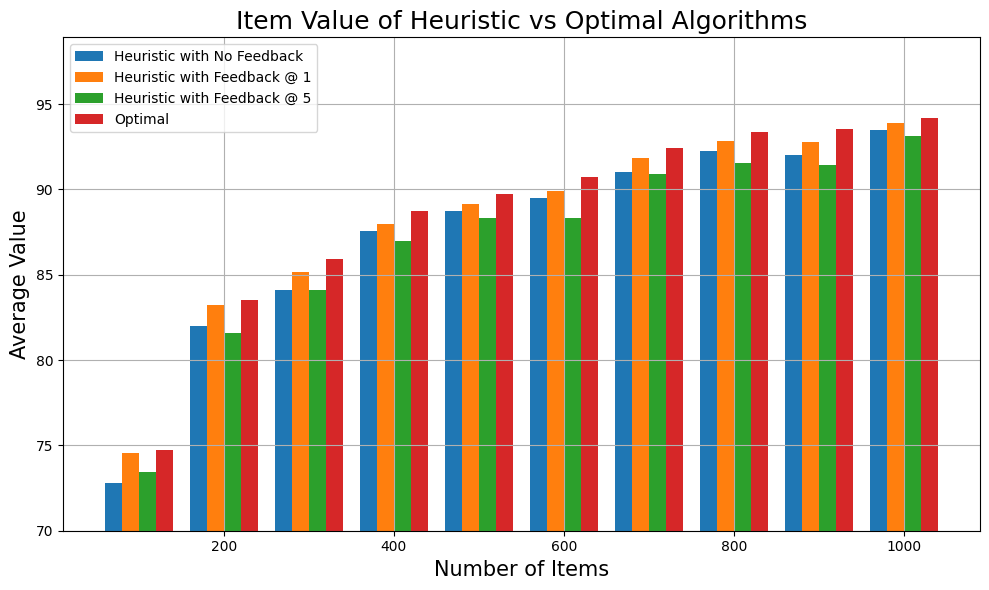

In [68]:
bar_width = 20
min_y = min(min(exact), min(approx1), min(approx2), min(approx3))
max_y = max(max(exact), max(approx1), max(approx2), max(approx3))
plt.figure(figsize=(10, 6))
plt.bar([i - 1.5 * bar_width for i in x[1::2]], approx1[1::2], width=bar_width, label='Heuristic with No Feedback')
plt.bar([i - 0.5 * bar_width for i in x[1::2]], approx2[1::2], width=bar_width, label='Heuristic with Feedback @ 1')
plt.bar([i + 0.5 * bar_width for i in x[1::2]], approx3[1::2], width=bar_width, label='Heuristic with Feedback @ 5')
plt.bar([i + 1.5 * bar_width for i in x[1::2]], exact[1::2], width=bar_width, label='Optimal')
plt.legend(loc='upper left')
plt.xlabel('Number of Items', fontsize=15)
plt.ylabel('Average Value', fontsize=15)
plt.ylim(70)
plt.title('Item Value of Heuristic vs Optimal Algorithms', fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/damonlin/Downloads/knapsack_value.pdf')

In [52]:
t1, t2, t3, t4 = [], [], [], []
capacity = 10000
x = range(50, 1001, 50)
k = 20

for i in tqdm(x):
    cost1, cost2, cost3, cost4 = 0, 0, 0, 0
    for _ in range(k):
        items = [(random.randint(500, 1000), random.randint(1, 5)) for _ in range(i)]
        start_time = time.time()
        bounded_knapsack(items, capacity)
        end_time = time.time()
        cost1 += (end_time - start_time)
        start_time = time.time()
        heuristic_bounded_knapsack(items, capacity)
        end_time = time.time()
        cost2 += (end_time - start_time)
        start_time = time.time()
        heuristic_bounded_knapsack2(items, capacity)
        end_time = time.time()
        cost3 += (end_time - start_time)
        start_time = time.time()
        heuristic_bounded_knapsack3(items, capacity)
        end_time = time.time()
        cost4 += (end_time - start_time)
    t1.append(cost1 / k)
    t2.append(cost2 / k)
    t3.append(cost3 / k)
    t4.append(cost4 / k)

100%|██████████| 20/20 [04:36<00:00, 13.83s/it]


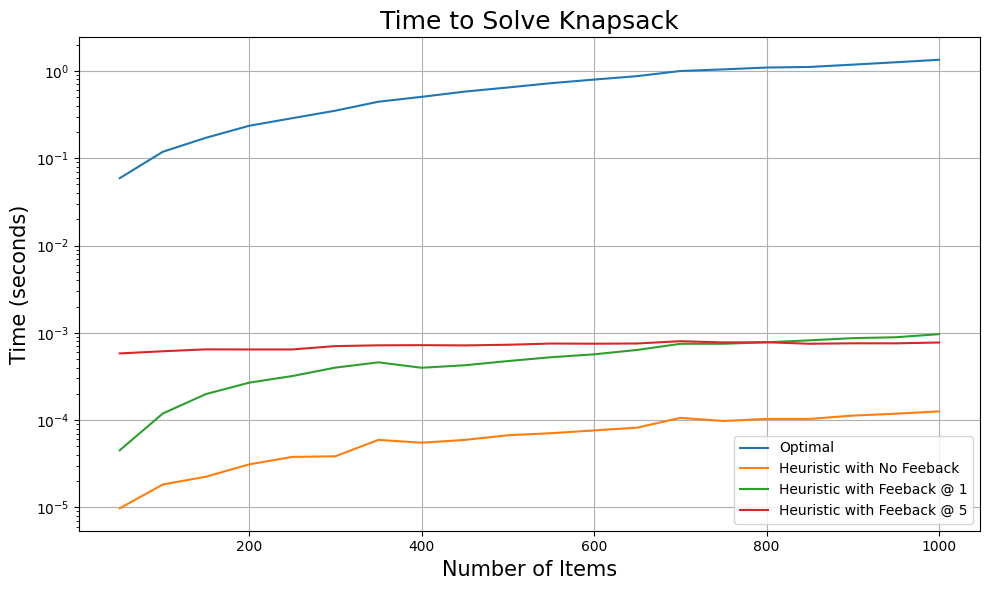

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(x, t1, label='Optimal')
plt.plot(x, t2, label='Heuristic with No Feeback')
plt.plot(x, t3, label='Heuristic with Feeback @ 1')
plt.plot(x, t4, label='Heuristic with Feeback @ 5')
plt.legend()
plt.xlabel('Number of Items', fontsize=15)
plt.ylabel('Time (seconds)', fontsize=15)
plt.title('Time to Solve Knapsack', fontsize=18)
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/damonlin/Downloads/knapsack_runtime.pdf')